# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [50%]

Spring 2022 semester.

Due date: **July 1st 2022.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file. 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display the average train and average test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The cross-entropy loss function computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given target.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each class, of size 28 by 28) after the last epoch. (Hint thread: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class].

**b)**   Now retrain the model for 10 epochs with each of the learning rates in the set {0.01, 0.1, 1, 10} and test the resulting model. Create a figure and plot the loss curves of each of the four runs for comparison. Explain the obtained (train and test) results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, stride 2, 16 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on CIFAR-10 and plot the training loss curve (avg. loss per epoch) and final test loss and accuracy, when training with or without the two 3x3 convolutional layers. 

**b)**  Give a breakdown of the number of parameters (per layer) within the above model, as well as the overall number.

# **Answer (1):**
create needed blocks of code (and results) below

In [23]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib
from matplotlib.ticker import MaxNLocator

In [24]:
def imshow(img1, img2, dataset, label):
    img1 = img1 / 2 + 0.5  # un-normalize
    img2 = img2 / 2 + 0.5
    np_img1, np_img2 = img1.numpy(), img2.numpy()

    plt.figure()
    plt.suptitle(dataset + " dataset average: Class " + label)
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(np_img1, (1, 2, 0)))
    plt.title('Train')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(np_img2, (1, 2, 0)))
    plt.title('Test')
    plt.show()

In [25]:
def show_average_images(train_loader, test_loader, dataset, labels):
    '''Plots the average image for each class in the dataset both for the training data and the test one'''
    
    train_counters, test_counters = [], []
    train_results, test_results = [], []
    
    for _ in range(len(labels)):
        train_counters.append(0)
        test_counters.append(0)
        train_results.append(None)
        test_results.append(None)
    
    dataiter = iter(train_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            mn_value = torch.min(img_temp)
            mx_value = torch.max(img_temp)
            
            img_temp -= mn_value
            
            img_temp /= (mx_value - mn_value)
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    train_counters[ind] += 1
                    if train_results[ind] is None:
                        train_results[ind] = img_temp
                    else:
                        train_results[ind] += img_temp

        except StopIteration:
            break

    dataiter = iter(test_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            mn_value = torch.min(img_temp)
            mx_value = torch.max(img_temp)
            
            img_temp -= mn_value
            
            img_temp /= (mx_value - mn_value)
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    test_counters[ind] += 1
                    if test_results[ind] is None:
                        test_results[ind] = img_temp
                    else:
                        test_results[ind] += img_temp

        except StopIteration:
            break
    
    for index, label in enumerate(labels):
        
        test_results[index] /= test_counters[index]
        train_results[index] /= train_counters[index]

        imshow(torchvision.utils.make_grid(train_results[index]), torchvision.utils.make_grid(test_results[index]), 
               dataset, labels[index])

Files already downloaded and verified
Files already downloaded and verified


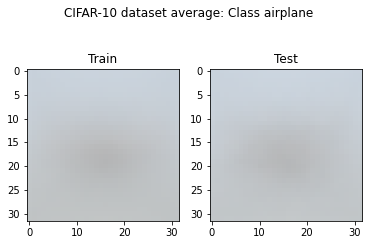

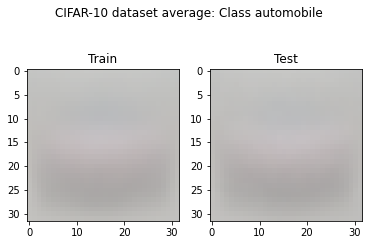

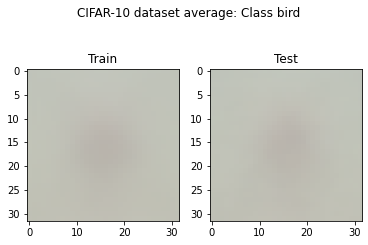

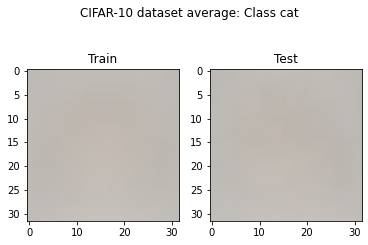

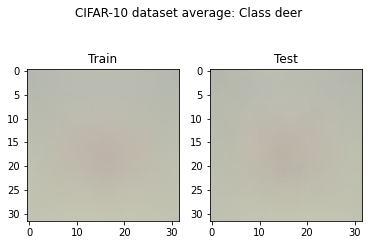

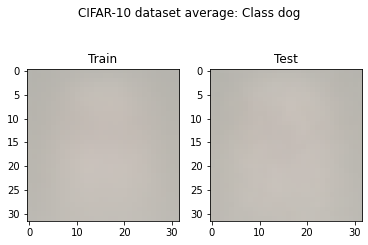

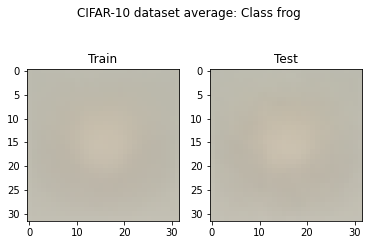

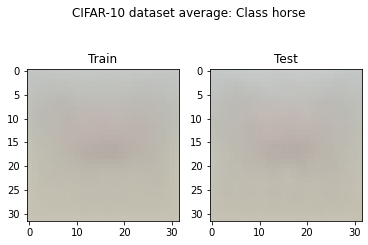

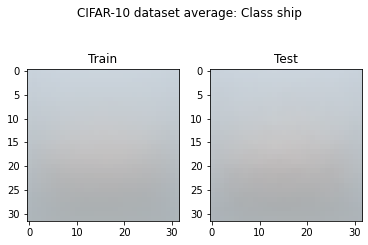

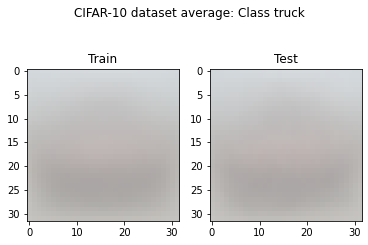

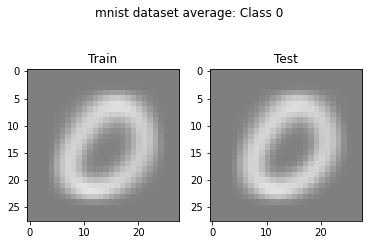

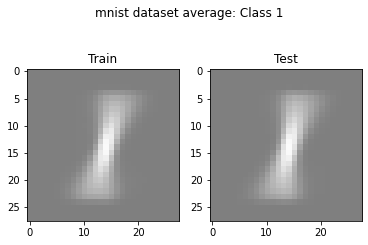

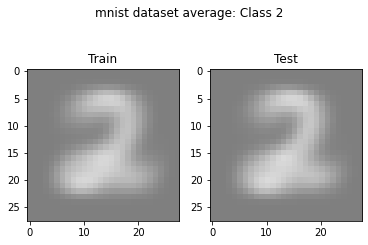

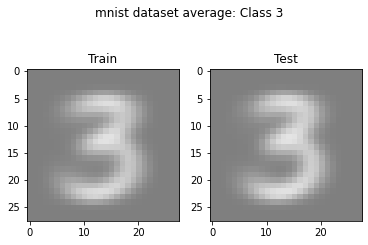

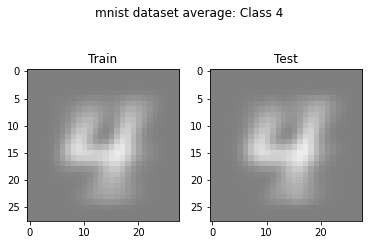

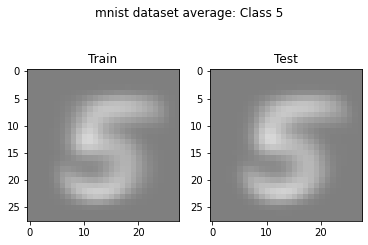

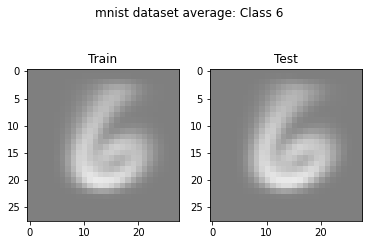

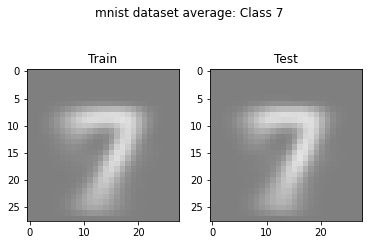

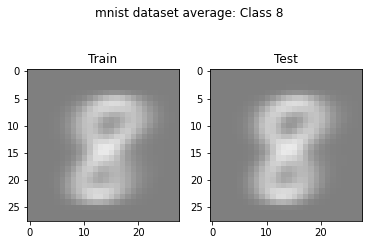

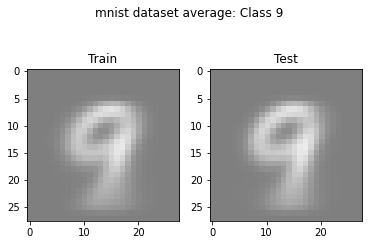

In [26]:
torch.utils.data.DataLoader.num_worker = 0

# building the transforms and data loaders

cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,
                                           download=True, transform=cifar_transform)

cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

cifar_test = torchvision.datasets.CIFAR10(root='.', train=False,
                                          download=True, transform=cifar_transform)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1,
                                                shuffle=False, num_workers=2)

mnist_train = torchvision.datasets.MNIST(root='.', train=True,
                                         download=True, transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

mnist_test = torchvision.datasets.MNIST(root='.', train=False,
                                        download=True, transform=mnist_transform)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1,
                                                shuffle=False, num_workers=2)

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_average_images(cifar_train_loader, cifar_test_loader, 'CIFAR-10', cifar_labels)
show_average_images(mnist_train_loader, mnist_test_loader, 'mnist', mnist_labels)

# **Answer (2):**
create needed blocks of code (and results) below

In [27]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [28]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [29]:
# train and test functions
def train(epoch, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [30]:
# Training and testing 
for i in range(1, epochs+1):
  train(i, mnist_train_loader)

# resetting the value of batch size in the DataLoader objects
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.925575
Train Epoch: 1 [100/60000 (0%)]	Loss: 0.018295
Train Epoch: 1 [200/60000 (0%)]	Loss: 4.207211
Train Epoch: 1 [300/60000 (0%)]	Loss: 0.012245
Train Epoch: 1 [400/60000 (1%)]	Loss: 0.032642
Train Epoch: 1 [500/60000 (1%)]	Loss: 0.001259
Train Epoch: 1 [600/60000 (1%)]	Loss: 0.516272
Train Epoch: 1 [700/60000 (1%)]	Loss: 0.000010
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.000049
Train Epoch: 1 [900/60000 (2%)]	Loss: 0.163040
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.000130
Train Epoch: 1 [1100/60000 (2%)]	Loss: 0.394149
Train Epoch: 1 [1200/60000 (2%)]	Loss: 0.056256
Train Epoch: 1 [1300/60000 (2%)]	Loss: 0.003357
Train Epoch: 1 [1400/60000 (2%)]	Loss: 0.057128
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.000000
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.024823
Train Epoch: 1 [1700/60000 (3%)]	Loss: 0.000002
Train Epoch: 1 [1800/60000 (3%)]	Loss: 0.000001
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.000485
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.002105
Trai

Train Epoch: 1 [17100/60000 (28%)]	Loss: 0.000000
Train Epoch: 1 [17200/60000 (29%)]	Loss: 0.161980
Train Epoch: 1 [17300/60000 (29%)]	Loss: 0.000018
Train Epoch: 1 [17400/60000 (29%)]	Loss: 0.000000
Train Epoch: 1 [17500/60000 (29%)]	Loss: 3.475250
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.011056
Train Epoch: 1 [17700/60000 (30%)]	Loss: 0.219877
Train Epoch: 1 [17800/60000 (30%)]	Loss: 0.000001
Train Epoch: 1 [17900/60000 (30%)]	Loss: 1.684647
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.000047
Train Epoch: 1 [18100/60000 (30%)]	Loss: 7.461689
Train Epoch: 1 [18200/60000 (30%)]	Loss: 10.694078
Train Epoch: 1 [18300/60000 (30%)]	Loss: 0.000153
Train Epoch: 1 [18400/60000 (31%)]	Loss: 0.001593
Train Epoch: 1 [18500/60000 (31%)]	Loss: 0.000000
Train Epoch: 1 [18600/60000 (31%)]	Loss: 0.000000
Train Epoch: 1 [18700/60000 (31%)]	Loss: 0.000000
Train Epoch: 1 [18800/60000 (31%)]	Loss: 0.000004
Train Epoch: 1 [18900/60000 (32%)]	Loss: 0.000000
Train Epoch: 1 [19000/60000 (32%)]	Loss: 4.815523

Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.001635
Train Epoch: 1 [34100/60000 (57%)]	Loss: 0.324480
Train Epoch: 1 [34200/60000 (57%)]	Loss: 2.240998
Train Epoch: 1 [34300/60000 (57%)]	Loss: 0.680796
Train Epoch: 1 [34400/60000 (57%)]	Loss: 0.000000
Train Epoch: 1 [34500/60000 (58%)]	Loss: 0.000047
Train Epoch: 1 [34600/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34700/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34800/60000 (58%)]	Loss: 0.000112
Train Epoch: 1 [34900/60000 (58%)]	Loss: 0.005047
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.000032
Train Epoch: 1 [35100/60000 (58%)]	Loss: 0.000004
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.000000
Train Epoch: 1 [35300/60000 (59%)]	Loss: 0.005192
Train Epoch: 1 [35400/60000 (59%)]	Loss: 0.052728
Train Epoch: 1 [35500/60000 (59%)]	Loss: 0.000001
Train Epoch: 1 [35600/60000 (59%)]	Loss: 0.110503
Train Epoch: 1 [35700/60000 (60%)]	Loss: 0.002869
Train Epoch: 1 [35800/60000 (60%)]	Loss: 0.022939
Train Epoch: 1 [35900/60000 (60%)]	Loss: 0.235676


Train Epoch: 1 [50700/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50800/60000 (85%)]	Loss: 0.000000
Train Epoch: 1 [50900/60000 (85%)]	Loss: 0.000003
Train Epoch: 1 [51000/60000 (85%)]	Loss: 0.001083
Train Epoch: 1 [51100/60000 (85%)]	Loss: 9.147730
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000295
Train Epoch: 1 [51300/60000 (86%)]	Loss: 0.027232
Train Epoch: 1 [51400/60000 (86%)]	Loss: 0.000023
Train Epoch: 1 [51500/60000 (86%)]	Loss: 2.098875
Train Epoch: 1 [51600/60000 (86%)]	Loss: 0.079242
Train Epoch: 1 [51700/60000 (86%)]	Loss: 0.000024
Train Epoch: 1 [51800/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51900/60000 (86%)]	Loss: 0.000163
Train Epoch: 1 [52000/60000 (87%)]	Loss: 3.606570
Train Epoch: 1 [52100/60000 (87%)]	Loss: 0.000001
Train Epoch: 1 [52200/60000 (87%)]	Loss: 0.001808
Train Epoch: 1 [52300/60000 (87%)]	Loss: 0.002757
Train Epoch: 1 [52400/60000 (87%)]	Loss: 0.018702
Train Epoch: 1 [52500/60000 (88%)]	Loss: 0.000000
Train Epoch: 1 [52600/60000 (88%)]	Loss: 0.001724


Train Epoch: 2 [7500/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7600/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [7700/60000 (13%)]	Loss: 0.000049
Train Epoch: 2 [7800/60000 (13%)]	Loss: 0.018192
Train Epoch: 2 [7900/60000 (13%)]	Loss: 12.690989
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.000209
Train Epoch: 2 [8100/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8200/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8300/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8400/60000 (14%)]	Loss: 0.000006
Train Epoch: 2 [8500/60000 (14%)]	Loss: 6.037115
Train Epoch: 2 [8600/60000 (14%)]	Loss: 3.510024
Train Epoch: 2 [8700/60000 (14%)]	Loss: 0.000058
Train Epoch: 2 [8800/60000 (15%)]	Loss: 2.051185
Train Epoch: 2 [8900/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [9000/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [9100/60000 (15%)]	Loss: 0.000001
Train Epoch: 2 [9200/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [9300/60000 (16%)]	Loss: 0.000000
Train Epoch: 2 [9400/60000 (16%)]	Loss: 0.000000
Train Epoch: 2 [950

Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.000001
Train Epoch: 2 [24100/60000 (40%)]	Loss: 0.040935
Train Epoch: 2 [24200/60000 (40%)]	Loss: 0.000003
Train Epoch: 2 [24300/60000 (40%)]	Loss: 0.000001
Train Epoch: 2 [24400/60000 (41%)]	Loss: 0.023890
Train Epoch: 2 [24500/60000 (41%)]	Loss: 0.011421
Train Epoch: 2 [24600/60000 (41%)]	Loss: 0.000005
Train Epoch: 2 [24700/60000 (41%)]	Loss: 1.648013
Train Epoch: 2 [24800/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24900/60000 (42%)]	Loss: 0.311869
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25100/60000 (42%)]	Loss: 0.000036
Train Epoch: 2 [25200/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25300/60000 (42%)]	Loss: 0.000003
Train Epoch: 2 [25400/60000 (42%)]	Loss: 0.000008
Train Epoch: 2 [25500/60000 (42%)]	Loss: 0.022878
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000034
Train Epoch: 2 [25700/60000 (43%)]	Loss: 0.000000
Train Epoch: 2 [25800/60000 (43%)]	Loss: 0.000000
Train Epoch: 2 [25900/60000 (43%)]	Loss: 0.008484


Train Epoch: 2 [40600/60000 (68%)]	Loss: 0.000005
Train Epoch: 2 [40700/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [40800/60000 (68%)]	Loss: 0.008038
Train Epoch: 2 [40900/60000 (68%)]	Loss: 0.276156
Train Epoch: 2 [41000/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41100/60000 (68%)]	Loss: 0.025213
Train Epoch: 2 [41200/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41300/60000 (69%)]	Loss: 0.167113
Train Epoch: 2 [41400/60000 (69%)]	Loss: 0.000020
Train Epoch: 2 [41500/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41700/60000 (70%)]	Loss: 0.000036
Train Epoch: 2 [41800/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [41900/60000 (70%)]	Loss: 0.000002
Train Epoch: 2 [42000/60000 (70%)]	Loss: 0.000199
Train Epoch: 2 [42100/60000 (70%)]	Loss: 0.000009
Train Epoch: 2 [42200/60000 (70%)]	Loss: 0.118017
Train Epoch: 2 [42300/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [42400/60000 (71%)]	Loss: 0.000000
Train Epoch: 2 [42500/60000 (71%)]	Loss: 0.000295


Train Epoch: 2 [57400/60000 (96%)]	Loss: 5.415122
Train Epoch: 2 [57500/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [57600/60000 (96%)]	Loss: 4.848313
Train Epoch: 2 [57700/60000 (96%)]	Loss: 0.000368
Train Epoch: 2 [57800/60000 (96%)]	Loss: 0.003839
Train Epoch: 2 [57900/60000 (96%)]	Loss: 0.000015
Train Epoch: 2 [58000/60000 (97%)]	Loss: 0.000711
Train Epoch: 2 [58100/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58200/60000 (97%)]	Loss: 0.000085
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.014521
Train Epoch: 2 [58400/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58500/60000 (98%)]	Loss: 0.000003
Train Epoch: 2 [58600/60000 (98%)]	Loss: 0.000004
Train Epoch: 2 [58700/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [58800/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [58900/60000 (98%)]	Loss: 0.000003
Train Epoch: 2 [59000/60000 (98%)]	Loss: 0.000178
Train Epoch: 2 [59100/60000 (98%)]	Loss: 11.403656
Train Epoch: 2 [59200/60000 (99%)]	Loss: 0.000000
Train Epoch: 2 [59300/60000 (99%)]	Loss: 0.000646

Train Epoch: 3 [14500/60000 (24%)]	Loss: 0.000105
Train Epoch: 3 [14600/60000 (24%)]	Loss: 2.459404
Train Epoch: 3 [14700/60000 (24%)]	Loss: 0.000046
Train Epoch: 3 [14800/60000 (25%)]	Loss: 1.410637
Train Epoch: 3 [14900/60000 (25%)]	Loss: 2.960497
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.002579
Train Epoch: 3 [15100/60000 (25%)]	Loss: 0.002083
Train Epoch: 3 [15200/60000 (25%)]	Loss: 1.760331
Train Epoch: 3 [15300/60000 (26%)]	Loss: 0.000001
Train Epoch: 3 [15400/60000 (26%)]	Loss: 0.051525
Train Epoch: 3 [15500/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15600/60000 (26%)]	Loss: 0.000008
Train Epoch: 3 [15700/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15800/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15900/60000 (26%)]	Loss: 0.001532
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.000009
Train Epoch: 3 [16100/60000 (27%)]	Loss: 0.000004
Train Epoch: 3 [16200/60000 (27%)]	Loss: 0.000001
Train Epoch: 3 [16300/60000 (27%)]	Loss: 0.676049
Train Epoch: 3 [16400/60000 (27%)]	Loss: 2.469906


Train Epoch: 3 [31000/60000 (52%)]	Loss: 3.208919
Train Epoch: 3 [31100/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31200/60000 (52%)]	Loss: 0.000027
Train Epoch: 3 [31300/60000 (52%)]	Loss: 0.000001
Train Epoch: 3 [31400/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31500/60000 (52%)]	Loss: 0.001469
Train Epoch: 3 [31600/60000 (53%)]	Loss: 0.049387
Train Epoch: 3 [31700/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.009449
Train Epoch: 3 [31900/60000 (53%)]	Loss: 0.063986
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [32100/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32200/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32300/60000 (54%)]	Loss: 0.255070
Train Epoch: 3 [32400/60000 (54%)]	Loss: 0.000001
Train Epoch: 3 [32500/60000 (54%)]	Loss: 0.000030
Train Epoch: 3 [32600/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32700/60000 (54%)]	Loss: 0.006881
Train Epoch: 3 [32800/60000 (55%)]	Loss: 0.000000
Train Epoch: 3 [32900/60000 (55%)]	Loss: 0.000135


Train Epoch: 3 [47900/60000 (80%)]	Loss: 0.006564
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48100/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48200/60000 (80%)]	Loss: 7.934959
Train Epoch: 3 [48300/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48400/60000 (81%)]	Loss: 0.015403
Train Epoch: 3 [48500/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48600/60000 (81%)]	Loss: 0.001056
Train Epoch: 3 [48700/60000 (81%)]	Loss: 0.000003
Train Epoch: 3 [48800/60000 (81%)]	Loss: 1.150584
Train Epoch: 3 [48900/60000 (82%)]	Loss: 0.046539
Train Epoch: 3 [49000/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49100/60000 (82%)]	Loss: 0.827219
Train Epoch: 3 [49200/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49300/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49400/60000 (82%)]	Loss: 0.028018
Train Epoch: 3 [49500/60000 (82%)]	Loss: 8.323772
Train Epoch: 3 [49600/60000 (83%)]	Loss: 0.000000
Train Epoch: 3 [49700/60000 (83%)]	Loss: 0.000008
Train Epoch: 3 [49800/60000 (83%)]	Loss: 0.000805


Train Epoch: 4 [4700/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [4800/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [4900/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5000/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5100/60000 (8%)]	Loss: 14.425402
Train Epoch: 4 [5200/60000 (9%)]	Loss: 0.000004
Train Epoch: 4 [5300/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5400/60000 (9%)]	Loss: 2.016694
Train Epoch: 4 [5500/60000 (9%)]	Loss: 0.000743
Train Epoch: 4 [5600/60000 (9%)]	Loss: 0.001840
Train Epoch: 4 [5700/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [5800/60000 (10%)]	Loss: 0.003164
Train Epoch: 4 [5900/60000 (10%)]	Loss: 0.000025
Train Epoch: 4 [6000/60000 (10%)]	Loss: 0.000020
Train Epoch: 4 [6100/60000 (10%)]	Loss: 0.001173
Train Epoch: 4 [6200/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [6300/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.000000
Train Epoch: 4 [6500/60000 (11%)]	Loss: 0.000000
Train Epoch: 4 [6600/60000 (11%)]	Loss: 0.048261
Train Epoch: 4 [6700/60000 (1

Train Epoch: 4 [21800/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [21900/60000 (36%)]	Loss: 0.002422
Train Epoch: 4 [22000/60000 (37%)]	Loss: 0.000065
Train Epoch: 4 [22100/60000 (37%)]	Loss: 0.001160
Train Epoch: 4 [22200/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22300/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22500/60000 (38%)]	Loss: 0.000012
Train Epoch: 4 [22600/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [22700/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [22800/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [22900/60000 (38%)]	Loss: 0.017649
Train Epoch: 4 [23000/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [23100/60000 (38%)]	Loss: 1.339216
Train Epoch: 4 [23200/60000 (39%)]	Loss: 0.000692
Train Epoch: 4 [23300/60000 (39%)]	Loss: 11.603645
Train Epoch: 4 [23400/60000 (39%)]	Loss: 0.000305
Train Epoch: 4 [23500/60000 (39%)]	Loss: 0.000000
Train Epoch: 4 [23600/60000 (39%)]	Loss: 0.000177
Train Epoch: 4 [23700/60000 (40%)]	Loss: 0.000101

Train Epoch: 4 [38600/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38700/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38800/60000 (65%)]	Loss: 0.000051
Train Epoch: 4 [38900/60000 (65%)]	Loss: 0.000046
Train Epoch: 4 [39000/60000 (65%)]	Loss: 2.135508
Train Epoch: 4 [39100/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39200/60000 (65%)]	Loss: 0.221734
Train Epoch: 4 [39300/60000 (66%)]	Loss: 0.000054
Train Epoch: 4 [39400/60000 (66%)]	Loss: 0.000004
Train Epoch: 4 [39500/60000 (66%)]	Loss: 0.000000
Train Epoch: 4 [39600/60000 (66%)]	Loss: 0.000378
Train Epoch: 4 [39700/60000 (66%)]	Loss: 0.006647
Train Epoch: 4 [39800/60000 (66%)]	Loss: 0.139930
Train Epoch: 4 [39900/60000 (66%)]	Loss: 0.000000
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.480809
Train Epoch: 4 [40100/60000 (67%)]	Loss: 0.000000
Train Epoch: 4 [40200/60000 (67%)]	Loss: 0.000000
Train Epoch: 4 [40300/60000 (67%)]	Loss: 0.015731
Train Epoch: 4 [40400/60000 (67%)]	Loss: 0.000000
Train Epoch: 4 [40500/60000 (68%)]	Loss: 0.710584


Train Epoch: 4 [55200/60000 (92%)]	Loss: 6.608444
Train Epoch: 4 [55300/60000 (92%)]	Loss: 6.206483
Train Epoch: 4 [55400/60000 (92%)]	Loss: 0.011804
Train Epoch: 4 [55500/60000 (92%)]	Loss: 7.944823
Train Epoch: 4 [55600/60000 (93%)]	Loss: 0.000014
Train Epoch: 4 [55700/60000 (93%)]	Loss: 2.674875
Train Epoch: 4 [55800/60000 (93%)]	Loss: 0.000093
Train Epoch: 4 [55900/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [56000/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [56100/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56200/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56300/60000 (94%)]	Loss: 0.000005
Train Epoch: 4 [56400/60000 (94%)]	Loss: 0.409475
Train Epoch: 4 [56500/60000 (94%)]	Loss: 0.000412
Train Epoch: 4 [56600/60000 (94%)]	Loss: 0.001173
Train Epoch: 4 [56700/60000 (94%)]	Loss: 0.002793
Train Epoch: 4 [56800/60000 (95%)]	Loss: 0.000138
Train Epoch: 4 [56900/60000 (95%)]	Loss: 0.660839
Train Epoch: 4 [57000/60000 (95%)]	Loss: 0.000000
Train Epoch: 4 [57100/60000 (95%)]	Loss: 0.000000


Train Epoch: 5 [12400/60000 (21%)]	Loss: 0.000002
Train Epoch: 5 [12500/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12600/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12700/60000 (21%)]	Loss: 0.013907
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12900/60000 (22%)]	Loss: 0.007393
Train Epoch: 5 [13000/60000 (22%)]	Loss: 0.000002
Train Epoch: 5 [13100/60000 (22%)]	Loss: 0.000004
Train Epoch: 5 [13200/60000 (22%)]	Loss: 2.259420
Train Epoch: 5 [13300/60000 (22%)]	Loss: 0.000435
Train Epoch: 5 [13400/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13500/60000 (22%)]	Loss: 0.141282
Train Epoch: 5 [13600/60000 (23%)]	Loss: 0.000005
Train Epoch: 5 [13700/60000 (23%)]	Loss: 0.000000
Train Epoch: 5 [13800/60000 (23%)]	Loss: 0.000008
Train Epoch: 5 [13900/60000 (23%)]	Loss: 0.000000
Train Epoch: 5 [14000/60000 (23%)]	Loss: 0.000000
Train Epoch: 5 [14100/60000 (24%)]	Loss: 0.000001
Train Epoch: 5 [14200/60000 (24%)]	Loss: 0.000015
Train Epoch: 5 [14300/60000 (24%)]	Loss: 0.000003


Train Epoch: 5 [29200/60000 (49%)]	Loss: 0.000001
Train Epoch: 5 [29300/60000 (49%)]	Loss: 0.000004
Train Epoch: 5 [29400/60000 (49%)]	Loss: 0.000005
Train Epoch: 5 [29500/60000 (49%)]	Loss: 0.004587
Train Epoch: 5 [29600/60000 (49%)]	Loss: 0.032035
Train Epoch: 5 [29700/60000 (50%)]	Loss: 0.000669
Train Epoch: 5 [29800/60000 (50%)]	Loss: 0.284740
Train Epoch: 5 [29900/60000 (50%)]	Loss: 0.733733
Train Epoch: 5 [30000/60000 (50%)]	Loss: 21.235172
Train Epoch: 5 [30100/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30200/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30300/60000 (50%)]	Loss: 0.000003
Train Epoch: 5 [30400/60000 (51%)]	Loss: 0.000295
Train Epoch: 5 [30500/60000 (51%)]	Loss: 0.000000
Train Epoch: 5 [30600/60000 (51%)]	Loss: 0.000004
Train Epoch: 5 [30700/60000 (51%)]	Loss: 0.000000
Train Epoch: 5 [30800/60000 (51%)]	Loss: 0.000000
Train Epoch: 5 [30900/60000 (52%)]	Loss: 0.000006
Train Epoch: 5 [31000/60000 (52%)]	Loss: 0.003012
Train Epoch: 5 [31100/60000 (52%)]	Loss: 0.000008

Train Epoch: 5 [45700/60000 (76%)]	Loss: 0.007829
Train Epoch: 5 [45800/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45900/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [46000/60000 (77%)]	Loss: 0.000947
Train Epoch: 5 [46100/60000 (77%)]	Loss: 0.317376
Train Epoch: 5 [46200/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46300/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46400/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46500/60000 (78%)]	Loss: 6.889612
Train Epoch: 5 [46600/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [46700/60000 (78%)]	Loss: 0.001160
Train Epoch: 5 [46800/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [46900/60000 (78%)]	Loss: 9.037723
Train Epoch: 5 [47000/60000 (78%)]	Loss: 0.000238
Train Epoch: 5 [47100/60000 (78%)]	Loss: 0.000002
Train Epoch: 5 [47200/60000 (79%)]	Loss: 0.000000
Train Epoch: 5 [47300/60000 (79%)]	Loss: 3.423283
Train Epoch: 5 [47400/60000 (79%)]	Loss: 0.000002
Train Epoch: 5 [47500/60000 (79%)]	Loss: 0.595356
Train Epoch: 5 [47600/60000 (79%)]	Loss: 0.000000


Train Epoch: 6 [2400/60000 (4%)]	Loss: 0.308798
Train Epoch: 6 [2500/60000 (4%)]	Loss: 0.000002
Train Epoch: 6 [2600/60000 (4%)]	Loss: 0.000115
Train Epoch: 6 [2700/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2800/60000 (5%)]	Loss: 0.000141
Train Epoch: 6 [2900/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3000/60000 (5%)]	Loss: 0.027755
Train Epoch: 6 [3100/60000 (5%)]	Loss: 1.586373
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.022828
Train Epoch: 6 [3300/60000 (6%)]	Loss: 0.006973
Train Epoch: 6 [3400/60000 (6%)]	Loss: 0.000001
Train Epoch: 6 [3500/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3600/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3700/60000 (6%)]	Loss: 0.007604
Train Epoch: 6 [3800/60000 (6%)]	Loss: 0.000167
Train Epoch: 6 [3900/60000 (6%)]	Loss: 0.000264
Train Epoch: 6 [4000/60000 (7%)]	Loss: 0.000116
Train Epoch: 6 [4100/60000 (7%)]	Loss: 0.000000
Train Epoch: 6 [4200/60000 (7%)]	Loss: 0.001189
Train Epoch: 6 [4300/60000 (7%)]	Loss: 0.004206
Train Epoch: 6 [4400/60000 (7%)]	Loss: 0

Train Epoch: 6 [19300/60000 (32%)]	Loss: 0.064452
Train Epoch: 6 [19400/60000 (32%)]	Loss: 0.000010
Train Epoch: 6 [19500/60000 (32%)]	Loss: 0.000704
Train Epoch: 6 [19600/60000 (33%)]	Loss: 0.000011
Train Epoch: 6 [19700/60000 (33%)]	Loss: 0.000099
Train Epoch: 6 [19800/60000 (33%)]	Loss: 0.020366
Train Epoch: 6 [19900/60000 (33%)]	Loss: 0.062306
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.000000
Train Epoch: 6 [20100/60000 (34%)]	Loss: 0.000004
Train Epoch: 6 [20200/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20300/60000 (34%)]	Loss: 0.000013
Train Epoch: 6 [20400/60000 (34%)]	Loss: 0.000072
Train Epoch: 6 [20500/60000 (34%)]	Loss: 0.000474
Train Epoch: 6 [20600/60000 (34%)]	Loss: 0.005241
Train Epoch: 6 [20700/60000 (34%)]	Loss: 0.000657
Train Epoch: 6 [20800/60000 (35%)]	Loss: 0.000003
Train Epoch: 6 [20900/60000 (35%)]	Loss: 0.000000
Train Epoch: 6 [21000/60000 (35%)]	Loss: 0.000054
Train Epoch: 6 [21100/60000 (35%)]	Loss: 0.335000
Train Epoch: 6 [21200/60000 (35%)]	Loss: 0.000191


Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.000017
Train Epoch: 6 [36100/60000 (60%)]	Loss: 0.000047
Train Epoch: 6 [36200/60000 (60%)]	Loss: 0.000881
Train Epoch: 6 [36300/60000 (60%)]	Loss: 2.781351
Train Epoch: 6 [36400/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36500/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36600/60000 (61%)]	Loss: 0.000034
Train Epoch: 6 [36700/60000 (61%)]	Loss: 0.000004
Train Epoch: 6 [36800/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36900/60000 (62%)]	Loss: 12.987140
Train Epoch: 6 [37000/60000 (62%)]	Loss: 0.015689
Train Epoch: 6 [37100/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37200/60000 (62%)]	Loss: 0.047391
Train Epoch: 6 [37300/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37400/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37500/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37600/60000 (63%)]	Loss: 0.000000
Train Epoch: 6 [37700/60000 (63%)]	Loss: 2.111803
Train Epoch: 6 [37800/60000 (63%)]	Loss: 0.000007
Train Epoch: 6 [37900/60000 (63%)]	Loss: 0.000005

Train Epoch: 6 [52500/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [52600/60000 (88%)]	Loss: 0.000001
Train Epoch: 6 [52700/60000 (88%)]	Loss: 0.000013
Train Epoch: 6 [52800/60000 (88%)]	Loss: 0.000099
Train Epoch: 6 [52900/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [53000/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [53100/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [53200/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53300/60000 (89%)]	Loss: 0.000093
Train Epoch: 6 [53400/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53500/60000 (89%)]	Loss: 0.000005
Train Epoch: 6 [53600/60000 (89%)]	Loss: 3.483323
Train Epoch: 6 [53700/60000 (90%)]	Loss: 0.000002
Train Epoch: 6 [53800/60000 (90%)]	Loss: 0.000283
Train Epoch: 6 [53900/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [54000/60000 (90%)]	Loss: 0.000007
Train Epoch: 6 [54100/60000 (90%)]	Loss: 0.000107
Train Epoch: 6 [54200/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [54300/60000 (90%)]	Loss: 0.000002
Train Epoch: 6 [54400/60000 (91%)]	Loss: 7.897003


Train Epoch: 7 [9500/60000 (16%)]	Loss: 3.137214
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.000010
Train Epoch: 7 [9700/60000 (16%)]	Loss: 0.000484
Train Epoch: 7 [9800/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [9900/60000 (16%)]	Loss: 0.951184
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.000002
Train Epoch: 7 [10100/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10200/60000 (17%)]	Loss: 0.000003
Train Epoch: 7 [10300/60000 (17%)]	Loss: 0.498745
Train Epoch: 7 [10400/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10500/60000 (18%)]	Loss: 0.000282
Train Epoch: 7 [10600/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10700/60000 (18%)]	Loss: 0.000001
Train Epoch: 7 [10800/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10900/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [11000/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [11100/60000 (18%)]	Loss: 2.035458
Train Epoch: 7 [11200/60000 (19%)]	Loss: 0.000000
Train Epoch: 7 [11300/60000 (19%)]	Loss: 0.000001
Train Epoch: 7 [11400/60000 (19%)]	Loss: 0.007877
Train

Train Epoch: 7 [26000/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [26100/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26200/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26300/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26400/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26500/60000 (44%)]	Loss: 9.956193
Train Epoch: 7 [26600/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26700/60000 (44%)]	Loss: 0.000021
Train Epoch: 7 [26800/60000 (45%)]	Loss: 0.002336
Train Epoch: 7 [26900/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [27000/60000 (45%)]	Loss: 0.000121
Train Epoch: 7 [27100/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [27200/60000 (45%)]	Loss: 15.163341
Train Epoch: 7 [27300/60000 (46%)]	Loss: 0.000606
Train Epoch: 7 [27400/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27500/60000 (46%)]	Loss: 0.000363
Train Epoch: 7 [27600/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27700/60000 (46%)]	Loss: 7.128040
Train Epoch: 7 [27800/60000 (46%)]	Loss: 0.000001
Train Epoch: 7 [27900/60000 (46%)]	Loss: 0.000000

Train Epoch: 7 [42800/60000 (71%)]	Loss: 4.113313
Train Epoch: 7 [42900/60000 (72%)]	Loss: 0.101436
Train Epoch: 7 [43000/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43100/60000 (72%)]	Loss: 0.006936
Train Epoch: 7 [43200/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43300/60000 (72%)]	Loss: 0.000051
Train Epoch: 7 [43400/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43500/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43600/60000 (73%)]	Loss: 0.000025
Train Epoch: 7 [43700/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [43800/60000 (73%)]	Loss: 1.705158
Train Epoch: 7 [43900/60000 (73%)]	Loss: 0.000018
Train Epoch: 7 [44000/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [44100/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44200/60000 (74%)]	Loss: 0.000712
Train Epoch: 7 [44300/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44400/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44500/60000 (74%)]	Loss: 3.177511
Train Epoch: 7 [44600/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44700/60000 (74%)]	Loss: 0.000000


Train Epoch: 7 [59500/60000 (99%)]	Loss: 0.000000
Train Epoch: 7 [59600/60000 (99%)]	Loss: 0.000001
Train Epoch: 7 [59700/60000 (100%)]	Loss: 0.001034
Train Epoch: 7 [59800/60000 (100%)]	Loss: 0.000004
Train Epoch: 7 [59900/60000 (100%)]	Loss: 0.125507
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000034
Train Epoch: 8 [100/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [200/60000 (0%)]	Loss: 2.150720
Train Epoch: 8 [300/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [400/60000 (1%)]	Loss: 0.003590
Train Epoch: 8 [500/60000 (1%)]	Loss: 0.000053
Train Epoch: 8 [600/60000 (1%)]	Loss: 2.680460
Train Epoch: 8 [700/60000 (1%)]	Loss: 0.007619
Train Epoch: 8 [800/60000 (1%)]	Loss: 0.000063
Train Epoch: 8 [900/60000 (2%)]	Loss: 0.034444
Train Epoch: 8 [1000/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1100/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1200/60000 (2%)]	Loss: 0.000002
Train Epoch: 8 [1300/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1400/60000 (2%)]	Loss: 5.314300
Train Epoch: 8 [1500/60000 (2%)]	Loss: 

Train Epoch: 8 [16500/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [16600/60000 (28%)]	Loss: 0.001600
Train Epoch: 8 [16700/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [16800/60000 (28%)]	Loss: 0.000761
Train Epoch: 8 [16900/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [17000/60000 (28%)]	Loss: 0.000208
Train Epoch: 8 [17100/60000 (28%)]	Loss: 0.000007
Train Epoch: 8 [17200/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17300/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17400/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17500/60000 (29%)]	Loss: 0.006976
Train Epoch: 8 [17600/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17700/60000 (30%)]	Loss: 3.772209
Train Epoch: 8 [17800/60000 (30%)]	Loss: 0.000004
Train Epoch: 8 [17900/60000 (30%)]	Loss: 0.000000
Train Epoch: 8 [18000/60000 (30%)]	Loss: 0.000000
Train Epoch: 8 [18100/60000 (30%)]	Loss: 0.000617
Train Epoch: 8 [18200/60000 (30%)]	Loss: 1.874234
Train Epoch: 8 [18300/60000 (30%)]	Loss: 0.000002
Train Epoch: 8 [18400/60000 (31%)]	Loss: 0.000143


Train Epoch: 8 [33300/60000 (56%)]	Loss: 0.000005
Train Epoch: 8 [33400/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33500/60000 (56%)]	Loss: 0.000683
Train Epoch: 8 [33600/60000 (56%)]	Loss: 3.275205
Train Epoch: 8 [33700/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33800/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33900/60000 (56%)]	Loss: 0.000007
Train Epoch: 8 [34000/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34100/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34200/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34300/60000 (57%)]	Loss: 3.324413
Train Epoch: 8 [34400/60000 (57%)]	Loss: 0.000367
Train Epoch: 8 [34500/60000 (58%)]	Loss: 0.000000
Train Epoch: 8 [34600/60000 (58%)]	Loss: 0.000000
Train Epoch: 8 [34700/60000 (58%)]	Loss: 0.000974
Train Epoch: 8 [34800/60000 (58%)]	Loss: 4.591568
Train Epoch: 8 [34900/60000 (58%)]	Loss: 0.000000
Train Epoch: 8 [35000/60000 (58%)]	Loss: 0.000215
Train Epoch: 8 [35100/60000 (58%)]	Loss: 0.000000
Train Epoch: 8 [35200/60000 (59%)]	Loss: 0.000962


Train Epoch: 8 [50100/60000 (84%)]	Loss: 0.038371
Train Epoch: 8 [50200/60000 (84%)]	Loss: 0.000477
Train Epoch: 8 [50300/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50400/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50500/60000 (84%)]	Loss: 0.000101
Train Epoch: 8 [50600/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50700/60000 (84%)]	Loss: 0.104408
Train Epoch: 8 [50800/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [50900/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [51000/60000 (85%)]	Loss: 1.097346
Train Epoch: 8 [51100/60000 (85%)]	Loss: 5.788936
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000001
Train Epoch: 8 [51300/60000 (86%)]	Loss: 0.000072
Train Epoch: 8 [51400/60000 (86%)]	Loss: 1.369335
Train Epoch: 8 [51500/60000 (86%)]	Loss: 0.510641
Train Epoch: 8 [51600/60000 (86%)]	Loss: 0.000710
Train Epoch: 8 [51700/60000 (86%)]	Loss: 0.000000
Train Epoch: 8 [51800/60000 (86%)]	Loss: 0.000000
Train Epoch: 8 [51900/60000 (86%)]	Loss: 0.000037
Train Epoch: 8 [52000/60000 (87%)]	Loss: 0.000000


Train Epoch: 9 [7300/60000 (12%)]	Loss: 0.000023
Train Epoch: 9 [7400/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7500/60000 (12%)]	Loss: 0.005665
Train Epoch: 9 [7600/60000 (13%)]	Loss: 1.360958
Train Epoch: 9 [7700/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [7800/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [7900/60000 (13%)]	Loss: 0.000018
Train Epoch: 9 [8000/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [8100/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8200/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8300/60000 (14%)]	Loss: 0.009097
Train Epoch: 9 [8400/60000 (14%)]	Loss: 0.010894
Train Epoch: 9 [8500/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8600/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8700/60000 (14%)]	Loss: 1.531064
Train Epoch: 9 [8800/60000 (15%)]	Loss: 0.000479
Train Epoch: 9 [8900/60000 (15%)]	Loss: 0.000000
Train Epoch: 9 [9000/60000 (15%)]	Loss: 0.458627
Train Epoch: 9 [9100/60000 (15%)]	Loss: 15.587627
Train Epoch: 9 [9200/60000 (15%)]	Loss: 0.000087
Train Epoch: 9 [930

Train Epoch: 9 [24100/60000 (40%)]	Loss: 0.054122
Train Epoch: 9 [24200/60000 (40%)]	Loss: 0.086784
Train Epoch: 9 [24300/60000 (40%)]	Loss: 0.000000
Train Epoch: 9 [24400/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24500/60000 (41%)]	Loss: 0.000001
Train Epoch: 9 [24600/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24700/60000 (41%)]	Loss: 0.000004
Train Epoch: 9 [24800/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24900/60000 (42%)]	Loss: 0.000000
Train Epoch: 9 [25000/60000 (42%)]	Loss: 0.004427
Train Epoch: 9 [25100/60000 (42%)]	Loss: 0.000989
Train Epoch: 9 [25200/60000 (42%)]	Loss: 0.000037
Train Epoch: 9 [25300/60000 (42%)]	Loss: 0.000000
Train Epoch: 9 [25400/60000 (42%)]	Loss: 0.000004
Train Epoch: 9 [25500/60000 (42%)]	Loss: 0.000000
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000041
Train Epoch: 9 [25700/60000 (43%)]	Loss: 9.326668
Train Epoch: 9 [25800/60000 (43%)]	Loss: 0.000000
Train Epoch: 9 [25900/60000 (43%)]	Loss: 0.000001
Train Epoch: 9 [26000/60000 (43%)]	Loss: 0.000000


Train Epoch: 9 [40600/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40700/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40800/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41000/60000 (68%)]	Loss: 0.210102
Train Epoch: 9 [41100/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41200/60000 (69%)]	Loss: 0.327959
Train Epoch: 9 [41300/60000 (69%)]	Loss: 0.000000
Train Epoch: 9 [41400/60000 (69%)]	Loss: 0.006268
Train Epoch: 9 [41500/60000 (69%)]	Loss: 0.000897
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.000237
Train Epoch: 9 [41700/60000 (70%)]	Loss: 4.689093
Train Epoch: 9 [41800/60000 (70%)]	Loss: 0.000000
Train Epoch: 9 [41900/60000 (70%)]	Loss: 0.000001
Train Epoch: 9 [42000/60000 (70%)]	Loss: 0.000000
Train Epoch: 9 [42100/60000 (70%)]	Loss: 0.000423
Train Epoch: 9 [42200/60000 (70%)]	Loss: 0.662739
Train Epoch: 9 [42300/60000 (70%)]	Loss: 0.003629
Train Epoch: 9 [42400/60000 (71%)]	Loss: 0.000001
Train Epoch: 9 [42500/60000 (71%)]	Loss: 0.130226


Train Epoch: 9 [57100/60000 (95%)]	Loss: 0.000000
Train Epoch: 9 [57200/60000 (95%)]	Loss: 0.000097
Train Epoch: 9 [57300/60000 (96%)]	Loss: 0.000001
Train Epoch: 9 [57400/60000 (96%)]	Loss: 0.047048
Train Epoch: 9 [57500/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57700/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57800/60000 (96%)]	Loss: 2.826212
Train Epoch: 9 [57900/60000 (96%)]	Loss: 0.000017
Train Epoch: 9 [58000/60000 (97%)]	Loss: 0.000000
Train Epoch: 9 [58100/60000 (97%)]	Loss: 0.677532
Train Epoch: 9 [58200/60000 (97%)]	Loss: 0.000000
Train Epoch: 9 [58300/60000 (97%)]	Loss: 0.000000
Train Epoch: 9 [58400/60000 (97%)]	Loss: 0.000000
Train Epoch: 9 [58500/60000 (98%)]	Loss: 0.000031
Train Epoch: 9 [58600/60000 (98%)]	Loss: 0.000000
Train Epoch: 9 [58700/60000 (98%)]	Loss: 2.304107
Train Epoch: 9 [58800/60000 (98%)]	Loss: 0.000000
Train Epoch: 9 [58900/60000 (98%)]	Loss: 0.000000
Train Epoch: 9 [59000/60000 (98%)]	Loss: 2.055249


Train Epoch: 10 [13800/60000 (23%)]	Loss: 0.000003
Train Epoch: 10 [13900/60000 (23%)]	Loss: 0.000055
Train Epoch: 10 [14000/60000 (23%)]	Loss: 0.000001
Train Epoch: 10 [14100/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14200/60000 (24%)]	Loss: 1.388473
Train Epoch: 10 [14300/60000 (24%)]	Loss: 0.000173
Train Epoch: 10 [14400/60000 (24%)]	Loss: 0.009559
Train Epoch: 10 [14500/60000 (24%)]	Loss: 0.000001
Train Epoch: 10 [14600/60000 (24%)]	Loss: 0.005779
Train Epoch: 10 [14700/60000 (24%)]	Loss: 0.000002
Train Epoch: 10 [14800/60000 (25%)]	Loss: 0.002527
Train Epoch: 10 [14900/60000 (25%)]	Loss: 13.938272
Train Epoch: 10 [15000/60000 (25%)]	Loss: 0.000000
Train Epoch: 10 [15100/60000 (25%)]	Loss: 0.000000
Train Epoch: 10 [15200/60000 (25%)]	Loss: 0.000046
Train Epoch: 10 [15300/60000 (26%)]	Loss: 0.000000
Train Epoch: 10 [15400/60000 (26%)]	Loss: 0.000000
Train Epoch: 10 [15500/60000 (26%)]	Loss: 0.000000
Train Epoch: 10 [15600/60000 (26%)]	Loss: 0.028381
Train Epoch: 10 [15700/60000 (

Train Epoch: 10 [29900/60000 (50%)]	Loss: 0.000179
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.000001
Train Epoch: 10 [30100/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [30200/60000 (50%)]	Loss: 2.577900
Train Epoch: 10 [30300/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [30400/60000 (51%)]	Loss: 0.000000
Train Epoch: 10 [30500/60000 (51%)]	Loss: 0.001279
Train Epoch: 10 [30600/60000 (51%)]	Loss: 0.000000
Train Epoch: 10 [30700/60000 (51%)]	Loss: 0.000266
Train Epoch: 10 [30800/60000 (51%)]	Loss: 0.000001
Train Epoch: 10 [30900/60000 (52%)]	Loss: 0.000000
Train Epoch: 10 [31000/60000 (52%)]	Loss: 0.000000
Train Epoch: 10 [31100/60000 (52%)]	Loss: 0.000001
Train Epoch: 10 [31200/60000 (52%)]	Loss: 0.000001
Train Epoch: 10 [31300/60000 (52%)]	Loss: 0.000000
Train Epoch: 10 [31400/60000 (52%)]	Loss: 0.000001
Train Epoch: 10 [31500/60000 (52%)]	Loss: 0.000000
Train Epoch: 10 [31600/60000 (53%)]	Loss: 0.000129
Train Epoch: 10 [31700/60000 (53%)]	Loss: 0.000000
Train Epoch: 10 [31800/60000 (5

Train Epoch: 10 [46100/60000 (77%)]	Loss: 0.002382
Train Epoch: 10 [46200/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46300/60000 (77%)]	Loss: 0.000002
Train Epoch: 10 [46400/60000 (77%)]	Loss: 4.684205
Train Epoch: 10 [46500/60000 (78%)]	Loss: 0.005361
Train Epoch: 10 [46600/60000 (78%)]	Loss: 0.000002
Train Epoch: 10 [46700/60000 (78%)]	Loss: 0.000032
Train Epoch: 10 [46800/60000 (78%)]	Loss: 0.000001
Train Epoch: 10 [46900/60000 (78%)]	Loss: 0.000045
Train Epoch: 10 [47000/60000 (78%)]	Loss: 0.000015
Train Epoch: 10 [47100/60000 (78%)]	Loss: 10.378266
Train Epoch: 10 [47200/60000 (79%)]	Loss: 0.004405
Train Epoch: 10 [47300/60000 (79%)]	Loss: 0.000038
Train Epoch: 10 [47400/60000 (79%)]	Loss: 0.000000
Train Epoch: 10 [47500/60000 (79%)]	Loss: 0.000000
Train Epoch: 10 [47600/60000 (79%)]	Loss: 0.000001
Train Epoch: 10 [47700/60000 (80%)]	Loss: 0.000000
Train Epoch: 10 [47800/60000 (80%)]	Loss: 0.000354
Train Epoch: 10 [47900/60000 (80%)]	Loss: 0.000014
Train Epoch: 10 [48000/60000 (

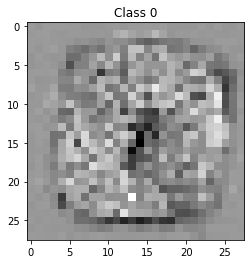

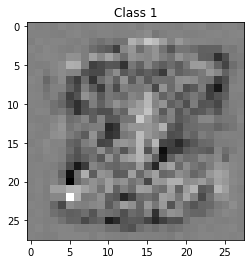

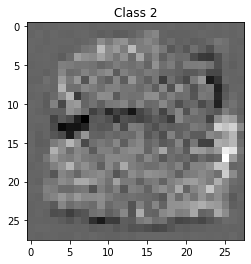

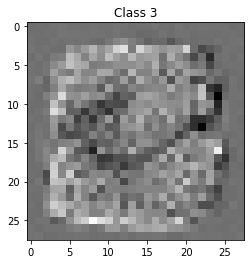

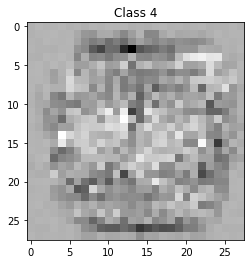

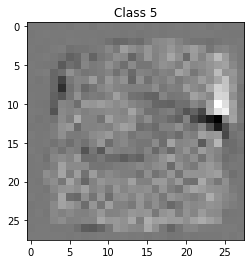

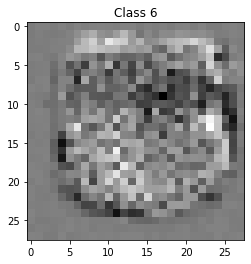

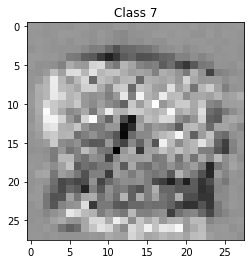

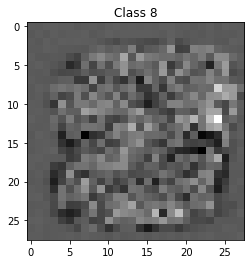

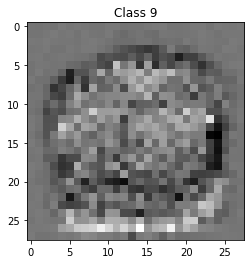

In [31]:
for parameter in network.parameters():
    for i in range(10):
        temp = torchvision.utils.make_grid(parameter[i].resize(28, 28))
        
        temp_np = temp.numpy()
        mx_val = np.amax(temp_np)
        mn_val = np.amin(temp_np)
        
        temp_np -= mn_val
        
        temp_np /= (mx_val - mn_val)
        
        plt.figure()
        plt.title("Class " + str(i))
        plt.imshow(np.transpose(temp_np, (1, 2, 0)))
        plt.show()
    
    break # we only need the first model parameter (weights)

In [32]:
limited_net = Net(num_inputs, num_outputs)
limited_optimizer = optim.SGD(limited_net.parameters(), lr=lr)
# train only on 50 examples

def limited_train(epoch, train_loader):
    limited_net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx >= 50:
            break
            
        data, target = Variable(data), Variable(target)
        limited_optimizer.zero_grad()
        output = limited_net(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        limited_optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def limited_test(test_loader):
    limited_net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = limited_net(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [33]:
# we shall use the same options

for i in range(1, epochs+1):
    limited_train(i, mnist_train_loader)

limited_test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.576224
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.685264
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.750872
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.666917
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.418006
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.560087
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.469051
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.472033
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.471461
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.282321

Test set: Average loss: 0.3676, Accuracy: 9004/10000 (90%)



# **Answer (3):**
create needed blocks of code (and results) below

In [34]:
def temp_train(epoch, train_loader):
    '''Trains the data and returns the loss mean for the current epoch'''
    network.train()
    
    loss_epoch = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        loss_epoch.append(loss.item())
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    loss_mean_epoch = np.mean(loss_epoch)
    return loss_mean_epoch

In [35]:
class MultiLayerNet(nn.Module):
    '''Class for the required CNN in Q3 containing a new hidden layer with 1000 units in it'''
    
    def __init__(self, num_inputs, num_outputs):
        super(MultiLayerNet, self).__init__()
        self.linear1 = nn.Linear(num_inputs, 1000)
        self.linear2 = nn.Linear(1000, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        return x

In [36]:
lr = 0.01

train_loss_curves = [[], [], [], []]

for i in range(4):
    print("Learning Rate: " + str(lr), end=2*'\n')
    
    network = MultiLayerNet(28 ** 2, 10)
    optimizer = optim.SGD(network.parameters(), lr=lr)
    
    # training the new model with the current learning rate
    
    for j in range(1, epochs+1):
        curr_loss_avg = temp_train(j, mnist_train_loader)
        train_loss_curves[i].append(curr_loss_avg)

    test(mnist_test_loader)
    
    lr *= 10 # updating the learning rate

Learning Rate: 0.01

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.284239
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.764385
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.465474
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.448012
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.397241
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.402933
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.304473
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.334965
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.417993
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.325449
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.282179
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.157053
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.401968
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.315797
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.453610
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.211111
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.637760
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.345314
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.399044
Train Epoch: 2 [57600/60000 (96%)]	Loss: 

Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.021617
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.006588
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.040423
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.019702
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.027030
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.049512
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.020730
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.024382
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.012109
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.008987
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.009935
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.010325
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.032863
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.010226
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.012965
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.013160
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.008192
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.031021
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.010741
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.001843
Train Epoch:

Train Epoch: 3 [38400/60000 (64%)]	Loss: 86.626938
Train Epoch: 3 [44800/60000 (75%)]	Loss: 178.268250
Train Epoch: 3 [51200/60000 (85%)]	Loss: 200.505524
Train Epoch: 3 [57600/60000 (96%)]	Loss: 361.148621
Train Epoch: 4 [0/60000 (0%)]	Loss: 485.100922
Train Epoch: 4 [6400/60000 (11%)]	Loss: 275.284729
Train Epoch: 4 [12800/60000 (21%)]	Loss: 489.115662
Train Epoch: 4 [19200/60000 (32%)]	Loss: 193.110657
Train Epoch: 4 [25600/60000 (43%)]	Loss: 313.271515
Train Epoch: 4 [32000/60000 (53%)]	Loss: 229.434982
Train Epoch: 4 [38400/60000 (64%)]	Loss: 179.894272
Train Epoch: 4 [44800/60000 (75%)]	Loss: 194.678665
Train Epoch: 4 [51200/60000 (85%)]	Loss: 417.913422
Train Epoch: 4 [57600/60000 (96%)]	Loss: 326.985931
Train Epoch: 5 [0/60000 (0%)]	Loss: 151.728577
Train Epoch: 5 [6400/60000 (11%)]	Loss: 301.001465
Train Epoch: 5 [12800/60000 (21%)]	Loss: 200.472183
Train Epoch: 5 [19200/60000 (32%)]	Loss: 227.451889
Train Epoch: 5 [25600/60000 (43%)]	Loss: 339.905609
Train Epoch: 5 [32000/600

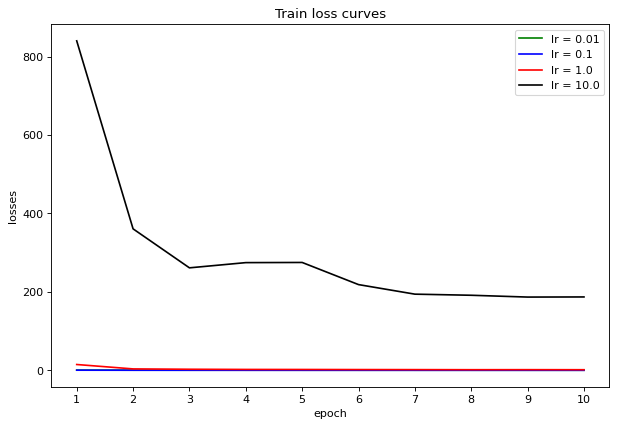

In [37]:
# plotting the loss curves for all four learning rates

colors = ['green', 'blue', 'red', 'black'] # the colors used for different lr in the plot

fg = plt.figure(figsize=(9, 6), dpi=80)
ax = fg.gca()

curr_lr = 0.01

for i in range(4):
    ax.plot(range(1, len(train_loss_curves[i]) + 1), train_loss_curves[i], '-', color=colors[i], label='lr = ' + str(curr_lr))
    curr_lr *= 10

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.title('Train loss curves')

plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(loc="upper right")

plt.show()

# **Answer (4):**
create needed blocks of code (and results) below

In [38]:
dataset = 'cifar10'
lr = 0.01

In [39]:
class ConvNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNet, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        
        # linear layers
        self.linear1 = nn.Linear(1600, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [40]:
epochs = 20
network = ConvNet(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

# train the new model and save the loss in the above list for the plot

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.290250
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.260427
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.073770
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.051544
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.927036
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.937262
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.927743
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.926386
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.876072
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.903285
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.875923
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.904622
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.775358
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.891036
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.782826
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.716124
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.887635
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.618286
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.602245
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.783518
Train Epoch: 3 [25

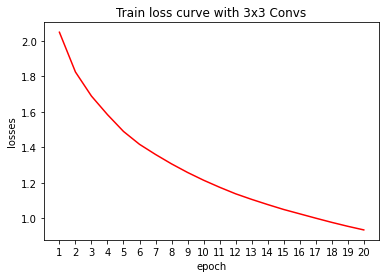

In [41]:
# plotting the loss curve for the training set

fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train loss curve with 3x3 Convs')

plt.show()

In [42]:
class ConvNetWithout3(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNetWithout3, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        
        # linear layers
        self.linear1 = nn.Linear(784, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [43]:
epochs = 20
network = ConvNetWithout3(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

# train the new model and save the loss in the above list for the plot

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304606
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.249749
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.152168
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.031919
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.913286
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.923473
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.832165
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.925136
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.729683
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.745140
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.772891
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.795753
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.603054
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.694896
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.707694
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.618020
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.687624
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.629236
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.662931
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.589541
Train Epoch: 3 [25

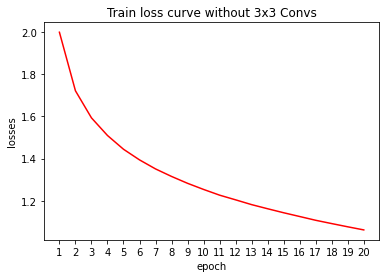

In [44]:
# plotting the loss curve for the training set

fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train loss curve without 3x3 Convs')

plt.show()